## Stackoverflow tag recommendation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import warnings; warnings.simplefilter('ignore')
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier

random_state = 123

## Question Data

Stackoverflow question data downloaded from Google BigQuery and aggregated into a single csv file. 

In [2]:
file = '../../../Data/stackoverflow/questions.csv'
df = pd.read_csv(file, usecols=['title', 'tags'])
df.head(10)

,title,tags
0,Issue with the webpack-bundler,webpack
1,Reducing queries on Firebase,javascript|firebase
2,Passing a Matrix from C++ to MATLAB,c++|matlab|matrix
3,window.onload vs. body.onload vs. document.onr...,javascript
4,How to display two fragments vertically (maste...,android|android-layout|listview|android-fragments
5,How to pass data from servlet to JSP without f...,java|jsp|servlets|jstl
6,collection from customer model is not retrievi...,collections|model|magento2
7,I need to generate and display a random number...,java|android|random
8,Cannot resolve bundle style,python|django|webpack
9,Python run set.intersection with set of sets a...,python-2.7


Data size

In [3]:
df.shape

(16389567, 2)

Data is too big for taining. We will only consider randomly selected 100,000 rows

In [4]:
df = shuffle(df, random_state=random_state)
df = df[:100000]

### Clean title text

In [5]:
def clean_text(text):
    text = str(text)
    text = re.sub(r"[^a-zA-Z0-9#+-]", " ", text.lower())
    return text

df['title'] = df['title'].apply(clean_text)
df.head(10)

,title,tags
6162563,gps returns one day ahead,android|gps
1172178,how to convert files to rar file node js,angularjs|node.js|rar
2996673,itextsharp not working in loop,c#|asp.net|itext
10409937,alter table modify column does not work in h...,java|sql|oracle|hsqldb|flyway
7895037,send data to broadcast receiver from mainactivity,android|broadcastreceiver
8374230,jquery mobile changepage failed,javascript|jquery|css3|jquery-mobile|dialog
7358055,jquery dynamic generate array,javascript|jquery
7333826,outside click on ipad device not working for a...,jquery|ipad
15668795,rails 4 - render previous template,ruby-on-rails|ruby|templates|ruby-on-rails-4
6026154,pulling an image online and rendering it throu...,django|image


### Save for later use

In [6]:
df.to_csv('../../../Data/stackoverflow/clean_questions.csv')

### Load data

In [23]:
df = pd.read_csv('../../../Data/stackoverflow/clean_questions.csv')
df.head(10)

,Unnamed: 0,title,tags
0,6162563,gps returns one day ahead,android|gps
1,1172178,how to convert files to rar file node js,angularjs|node.js|rar
2,2996673,itextsharp not working in loop,c#|asp.net|itext
3,10409937,alter table modify column does not work in h...,java|sql|oracle|hsqldb|flyway
4,7895037,send data to broadcast receiver from mainactivity,android|broadcastreceiver
5,8374230,jquery mobile changepage failed,javascript|jquery|css3|jquery-mobile|dialog
6,7358055,jquery dynamic generate array,javascript|jquery
7,7333826,outside click on ipad device not working for a...,jquery|ipad
8,15668795,rails 4 - render previous template,ruby-on-rails|ruby|templates|ruby-on-rails-4
9,6026154,pulling an image online and rendering it throu...,django|image


### Save data as list and basic exploration

In [24]:
questions = df['title'].tolist()
tags = df['tags'].tolist()

Find the number of words in the vocabulary

In [25]:
print('The total number of words in the data is: ', sum([len(text.split()) for text in questions]))

def tokenize_question(text):
    return text.split()

question_vect = CountVectorizer(tokenizer=tokenize_question)
question_vect.fit(questions)

print('The number of words in the vocabulary is: ', len(question_vect.vocabulary_))

The total number of words in the data is:  880213
The number of words in the vocabulary is:  37250


Find the number of tags

In [26]:
def tokenize_tags(text):
    return text.split('|')

tags_vect = CountVectorizer(tokenizer=tokenize_tags)
tags_vect.fit(tags)

print('The total number of tags is: ', len(tags_vect.vocabulary_))

The total number of tags is:  18837


#### Save tag label as vectorized tokens.

There are too many tags to predict. In our model we will only look at the top 100 tags and save the result

In [27]:
max_tags = 500

def tokenize_tags(text):
    return text.split('|')

tags_vect = CountVectorizer(tokenizer=tokenize_tags, max_features=max_tags)
tags = tags_vect.fit_transform(tags)
tags = tags.toarray()
print('Number of tags: ', len(tags_vect.vocabulary_))

tags_token = tags_vect.get_feature_names()
tag_frequency = tags.sum(axis=0)
print('The list of tags with frequency is: ')
print(dict(zip(tags_token, tag_frequency)))

Number of tags:  500
The list of tags with frequency is: 
{'.htaccess': 389, '.net': 1685, '3d': 90, 'actionscript-3': 291, 'active-directory': 82, 'activerecord': 151, 'ajax': 1126, 'algorithm': 566, 'amazon-ec2': 138, 'amazon-s3': 149, 'amazon-web-services': 375, 'android': 7088, 'android-activity': 179, 'android-asynctask': 87, 'android-fragments': 215, 'android-intent': 152, 'android-layout': 293, 'android-listview': 98, 'android-recyclerview': 80, 'android-studio': 267, 'angular': 764, 'angularjs': 1545, 'angularjs-directive': 104, 'animation': 216, 'ant': 94, 'apache': 526, 'apache-spark': 251, 'api': 349, 'arraylist': 193, 'arrays': 1752, 'asp.net': 2034, 'asp.net-core': 133, 'asp.net-mvc': 1038, 'asp.net-mvc-3': 249, 'asp.net-mvc-4': 257, 'asp.net-mvc-5': 79, 'asp.net-web-api': 139, 'assembly': 182, 'asynchronous': 211, 'audio': 180, 'authentication': 216, 'autocomplete': 81, 'automation': 91, 'awk': 129, 'azure': 399, 'backbone.js': 130, 'background': 82, 'bash': 622, 'batch-f

Histogram of number of tags in each question

Text(0,0.5,'Number of questions')

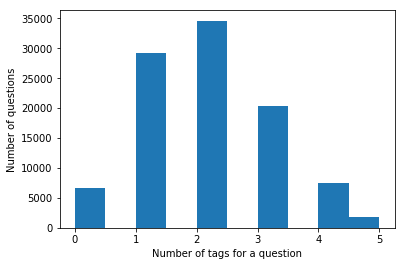

In [28]:
plt.hist(tags.sum(axis=1))
plt.xlabel('Number of tags for a question')
plt.ylabel('Number of questions')

### Split test and train data set

In [29]:
X_train, X_test, y_train, y_test = train_test_split(questions, tags, 
                                                    test_size=0.1, 
                                                    random_state=random_state)

### Sample weight
Evaluate sample weight from y_train data

In [30]:
sample_weight = compute_sample_weight('balanced', y_test)
sample_weight

array([1.35245077e-148, 7.79405469e-145, 9.16483803e-148, ...,
       4.25393746e-143, 3.83532791e-144, 6.37074127e-149])

In [31]:
len(X_train)

90000

### Evaluation metrics

In [32]:
def eval_metrics(y_test, y_predicted, print_metrics=True):
    
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    if print_metrics:
        print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (
            accuracy, precision, recall, f1))
    return accuracy, precision, recall, f1


# Simple first order model: Bag of words with logistic regression


### Bag of words embedding for quesitons

Remove common words and words appearing very less number of times from the corpus

In [33]:
def tokenize_question(text):
    return text.split()

bag_vect = CountVectorizer(tokenizer=tokenize_question,
                               stop_words='english',
                               min_df=4,
                               max_df=0.5)

X_train_bag = bag_vect.fit_transform(X_train)
X_test_bag = bag_vect.transform(X_test)
print('The number of words in the vocabulary is: ', len(bag_vect.vocabulary_))

The number of words in the vocabulary is:  8267


### Logistic regression with binary relevance
Since this is a multi-label classificaiton, we will use binary relevance on top of logistical regression. This basically splits each label as a seperate classification. 

In [ ]:
%%time
bag_log_clf = OneVsRestClassifier(LogisticRegression())

bag_log_clf.fit(X_train_bag, y_train)

print('Train score')
y_train_bag_predict = bag_log_clf.predict(X_train_bag)
eval_metrics(y_train, y_train_bag_predict)

print('Test score')
y_test_bag_predict = bag_log_clf.predict(X_test_bag)
eval_metrics(y_test, y_test_bag_predict)

### Important words

In [ ]:
importances = importances = bag_log_clf.estimators_[0].coef_[0]
for i in range(1,len(bag_log_clf.estimators_)):
    importances += bag_log_clf.estimators_[i].coef_[0]

importances = importances/sum(importances)
    
feature_imps = {'importances':importances, 'feature':bag_vect.get_feature_names()}
feature_imps = pd.DataFrame(feature_imps)
feature_imps = feature_imps.sort_values('importances', ascending=False)
# Normalize importance and add cumulative importance
feature_imps['cum_imp'] = feature_imps['importances'].cumsum()
feature_imps['importances'] = feature_imps['importances']/feature_imps['importances'].max()
feature_imps = feature_imps.reset_index(drop=True)
feature_imps['no_features'] = feature_imps.index + 1
feature_imps[['feature', 'importances', 'cum_imp']].head(20)

## TFIDF with logistic regression and binary relevance

### TFIDF on bag of words embedding for quesitons

In [ ]:
def tokenize_question(text):
    return text.split()

tfidf_vect = TfidfVectorizer(tokenizer=tokenize_question,
                               stop_words='english',
                               min_df=4,
                               max_df=0.5)

X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)
print('The number of words in the vocabulary is: ', len(tfidf_vect.vocabulary_))

### Logistic regression with binary relevance

In [ ]:
%%time
tfidf_log_clf = OneVsRestClassifier(LogisticRegression())

tfidf_log_clf.fit(X_train_tfidf, y_train)

print('Train score')
y_train_tfidf_predict = tfidf_log_clf.predict(X_train_tfidf)
eval_metrics(y_train, y_train_tfidf_predict)

print('Test score')
y_test_tfidf_predict = tfidf_log_clf.predict(X_test_tfidf)
eval_metrics(y_test, y_test_tfidf_predict)

### Importance words

In [ ]:
importances = importances = tfidf_log_clf.estimators_[0].coef_[0]
for i in range(1,len(tfidf_log_clf.estimators_)):
    importances += tfidf_log_clf.estimators_[i].coef_[0]

importances = importances/sum(importances)
    
feature_imps = {'importances':importances, 'feature':bag_vect.get_feature_names()}
feature_imps = pd.DataFrame(feature_imps)
feature_imps = feature_imps.sort_values('importances', ascending=False)
# Normalize importance and add cumulative importance
feature_imps['cum_imp'] = feature_imps['importances'].cumsum()
feature_imps['importances'] = feature_imps['importances']/feature_imps['importances'].max()
feature_imps = feature_imps.reset_index(drop=True)
feature_imps['no_features'] = feature_imps.index + 1
feature_imps[['feature', 'importances', 'cum_imp']].head(20)